# Query AODN parquet dataset:

Using a python class ```GetAodn``` to:
- retrieve as a dictionnary all metadata from all parquet dataset available on a S3 bucket 
- search for dataset containing specific variable/attributes ....
- retrieve data from a dataset with time, bounding box and scalar filter as a panda dataframe

In [1]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    os.system('uv pip install --system -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')
else:
    os.system('uv venv')
    os.system('uv pip install -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')

Using Python 3.10.14 interpreter at: /home/raymond/anaconda3/envs/data-access-service/bin/python3
Creating virtualenv at: .venv
Activate with: source .venv/bin/activate
Audited 127 packages in 485ms


In [2]:
import requests
import os
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/ParquetDataQuery.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)


In [3]:
from parquet_queries import GetAodn, create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, get_spatial_extent, get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import os
import pandas as pd
import pyarrow.compute as pc
import boto3
from fuzzywuzzy import fuzz
from botocore import UNSIGNED
from botocore.client import Config
from functools import lru_cache

# GetAodn Class

## Examples to use class

In [4]:
aodn_instance = GetAodn()

### Retrieving all parquet dataset information

In [5]:
# Creating a subinstance to use caching capability (maybe there's a cleaner way)
aodn_meta = aodn_instance.get_metadata()  
aodn_meta.metadata_catalog()

Error processing metadata from cloud_optimised/cluster_testing/vessel_co2_delayed_qc.parquet/, [Errno 2] Path does not exist 'imos-data-lab-optimised/cloud_optimised/cluster_testing/vessel_co2_delayed_qc.parquet/_common_metadata'. Detail: [errno 2] No such file or directory


{'argo': {'DATA_TYPE': {'type': 'string',
   'long_name': 'Data type',
   'conventions': 'Argo reference table 1'},
  'FORMAT_VERSION': {'type': 'string', 'long_name': 'File format version'},
  'HANDBOOK_VERSION': {'type': 'string', 'long_name': 'Data handbook version'},
  'REFERENCE_DATE_TIME': {'type': 'string',
   'long_name': 'Date of reference for Julian days',
   'conventions': 'YYYYMMDDHHMISS'},
  'DATE_CREATION': {'type': 'string',
   'long_name': 'Date of file creation',
   'conventions': 'YYYYMMDDHHMISS'},
  'DATE_UPDATE': {'type': 'string',
   'long_name': 'Date of update of this file',
   'conventions': 'YYYYMMDDHHMISS'},
  'PLATFORM_NUMBER': {'type': 'string',
   'long_name': 'Float unique identifier',
   'conventions': 'WMO float identifier : A9IIIII'},
  'PROJECT_NAME': {'type': 'string', 'long_name': 'Name of the project'},
  'PI_NAME': {'type': 'string',
   'long_name': 'Name of the principal investigator'},
  'STATION_PARAMETERS': {'type': 'string',
   'long_name': 'L

### Find all dataset containing specific information (such as temperature)

In [6]:
aodn_meta.find_datasets_with_attribute('temp', target_key='standard_name' )

['vessel_xbt_realtime_nonqc',
 'argo',
 'mooring_temperature_logger_delayed_qc',
 'vessel_xbt_delayed_qc',
 'vessel_trv_realtime_qc',
 'slocum_glider_delayed_qc2',
 'mooring_hourly_timeseries_delayed_qc',
 'slocum_glider_delayed_qc',
 'mooring_ctd_delayed_qc',
 'vessel_trv_realtime_qc_2',
 'vessel_sst_delayed_qc',
 'vessel_fishsoop_realtime_qc']

### Get SOOP XBT data

In [7]:
aodn_instance.get_dataset('vessel_xbt_realtime_nonqc').get_temporal_extent()

(datetime.datetime(2020, 9, 1, 10, 0), datetime.datetime(2024, 6, 1, 10, 0))

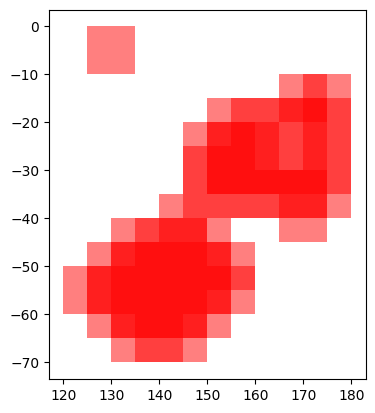

In [8]:
aodn_instance.get_dataset('vessel_xbt_realtime_nonqc').plot_spatial_extent()

In [9]:
df = aodn_instance.get_dataset('vessel_xbt_realtime_nonqc').get_data(date_start='2023-01-31 10:14:00', 
                                                   date_end='2024-02-01 07:50:00',
                                                   lat_min=-34, lat_max=-32, lon_min=150, lon_max=155)

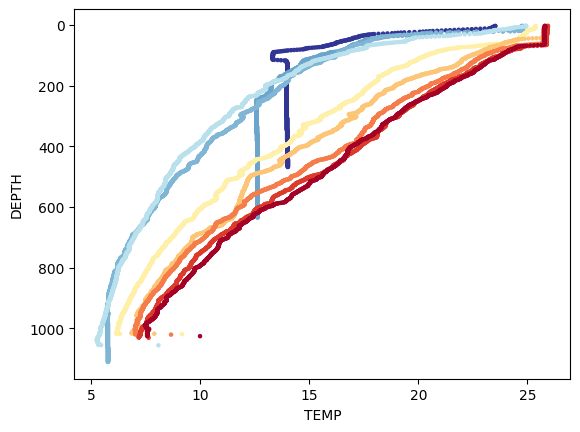

In [10]:
df[df['TEMP_quality_control'] == 1].sort_values('TIME').plot.scatter(x='TEMP', y='DEPTH', c='TIME',                                                                      
                                                                     cmap='RdYlBu_r', marker='.', linestyle="None").invert_yaxis()

In [11]:
df

,TIME,LATITUDE,LONGITUDE,DEPTH,DEPTH_quality_control,TEMP,TEMP_quality_control,imo_number,ship_name,Callsign,filename,XBT_line,timestamp,polygon
0,2024-01-28 05:41:00,-32.97142,151.99845,0.00,9.0,23.59,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
1,2024-01-28 05:41:00,-32.97142,151.99845,0.67,9.0,23.58,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
2,2024-01-28 05:41:00,-32.97142,151.99845,1.34,9.0,23.57,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
3,2024-01-28 05:41:00,-32.97142,151.99845,2.01,9.0,23.56,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
4,2024-01-28 05:41:00,-32.97142,151.99845,2.68,9.0,23.54,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14188,2024-01-28 21:01:00,-33.20854,154.99796,1107.43,9.0,36.26,4.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T210100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
14189,2024-01-28 21:01:00,-33.20854,154.99796,1108.17,9.0,36.26,4.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T210100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
14190,2024-01-28 21:01:00,-33.20854,154.99796,1108.91,9.0,36.26,4.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T210100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
14191,2024-01-28 21:01:00,-33.20854,154.99796,1109.65,9.0,36.26,4.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T210100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...


### Get anmn hourly timeseries

In [12]:
aodn_instance = GetAodn()

In [13]:
aodn_instance.get_dataset('mooring_hourly_timeseries_delayed_qc').get_temporal_extent()

(datetime.datetime(2007, 7, 1, 10, 0), datetime.datetime(2024, 4, 1, 11, 0))

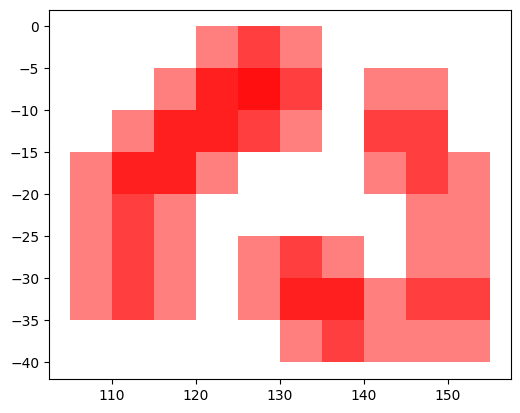

In [14]:
aodn_instance.get_dataset('mooring_hourly_timeseries_delayed_qc').plot_spatial_extent()

### Filter hourly timeseries for site BMP070

In [15]:
df = aodn_instance.get_dataset('mooring_hourly_timeseries_delayed_qc').get_data(date_start='2010-01-01 10:14:00', date_end='2024-02-01 07:50:00',
                                                                  scalar_filter={"site_code": "BMP070"})                                               

In [16]:
df

,instrument_index,instrument_id,source_file,TIME,LONGITUDE,LATITUDE,NOMINAL_DEPTH,DEPTH,DEPTH_count,DEPTH_min,...,DOXS_max,DOXS_count,PAR,PAR_std,PAR_min,PAR_max,PAR_count,site_code,timestamp,polygon
0,0,BMP070-1411; Aquatec Aqualogger 520PT; 023-1297,IMOS/ANMN/NSW/BMP070/Temperature/IMOS_ANMN-NSW...,2014-11-18 22:00:00,150.188517,-36.189700,32.000000,37.476677,7.0,37.431244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1412121600,0103000000010000000500000000000000002062400000...
1,0,BMP070-1411; Aquatec Aqualogger 520PT; 023-1297,IMOS/ANMN/NSW/BMP070/Temperature/IMOS_ANMN-NSW...,2014-11-18 23:00:00,150.188517,-36.189700,32.000000,37.279091,12.0,37.172100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1412121600,0103000000010000000500000000000000002062400000...
2,0,BMP070-1411; Aquatec Aqualogger 520PT; 023-1297,IMOS/ANMN/NSW/BMP070/Temperature/IMOS_ANMN-NSW...,2014-11-19 00:00:00,150.188517,-36.189700,32.000000,37.049400,12.0,36.948299,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1412121600,0103000000010000000500000000000000002062400000...
3,0,BMP070-1411; Aquatec Aqualogger 520PT; 023-1297,IMOS/ANMN/NSW/BMP070/Temperature/IMOS_ANMN-NSW...,2014-11-19 01:00:00,150.188517,-36.189700,32.000000,36.874191,12.0,36.812851,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1412121600,0103000000010000000500000000000000002062400000...
4,0,BMP070-1411; Aquatec Aqualogger 520PT; 023-1297,IMOS/ANMN/NSW/BMP070/Temperature/IMOS_ANMN-NSW...,2014-11-19 02:00:00,150.188517,-36.189700,32.000000,36.788300,12.0,36.753952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1412121600,0103000000010000000500000000000000002062400000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705071,252,BMP070-2312; Teledyne RD sentinel; 13679,IMOS/ANMN/NSW/BMP070/Velocity/IMOS_ANMN-NSW_AE...,2024-02-01 03:00:00,150.189433,-36.190967,71.900002,74.442268,12.0,74.402573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1704067200,0103000000010000000500000000000000002062400000...
705072,252,BMP070-2312; Teledyne RD sentinel; 13679,IMOS/ANMN/NSW/BMP070/Velocity/IMOS_ANMN-NSW_AE...,2024-02-01 04:00:00,150.189433,-36.190967,71.900002,74.290688,12.0,74.214027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1704067200,0103000000010000000500000000000000002062400000...
705073,252,BMP070-2312; Teledyne RD sentinel; 13679,IMOS/ANMN/NSW/BMP070/Velocity/IMOS_ANMN-NSW_AE...,2024-02-01 05:00:00,150.189433,-36.190967,71.900002,74.101486,12.0,73.975876,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1704067200,0103000000010000000500000000000000002062400000...
705074,252,BMP070-2312; Teledyne RD sentinel; 13679,IMOS/ANMN/NSW/BMP070/Velocity/IMOS_ANMN-NSW_AE...,2024-02-01 06:00:00,150.189433,-36.190967,71.900002,73.906662,12.0,73.825050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BMP070,1704067200,0103000000010000000500000000000000002062400000...


### Create a "climatology" for BPM070 at NOMINAL_DEPTH=52

Create a new variable **TEMP_CLIMATOLOGY** which is the daily mean over the available years.

In [17]:
# create a new variable DAY_MONTH in order to filter the data later on..
df['DAY_MONTH'] = df['TIME'].dt.strftime('%m-%d')

# Group by day and month, calculate daily mean temperature
daily_mean = df.groupby('DAY_MONTH')['TEMP'].mean().reset_index()
daily_mean.columns = ['DAY_MONTH', 'TEMP_CLIMATOLOGY']

# Merge back to original DataFrame on DAY_MONTH
df = pd.merge(df, daily_mean, on='DAY_MONTH', how='left')

# Drop the intermediate column 'DAY_MONTH'
df.drop('DAY_MONTH', axis=1, inplace=True)

#### Plot the TEMP variable and TEMP_CLIMATOLOGY together

#### Non-Interactive plot

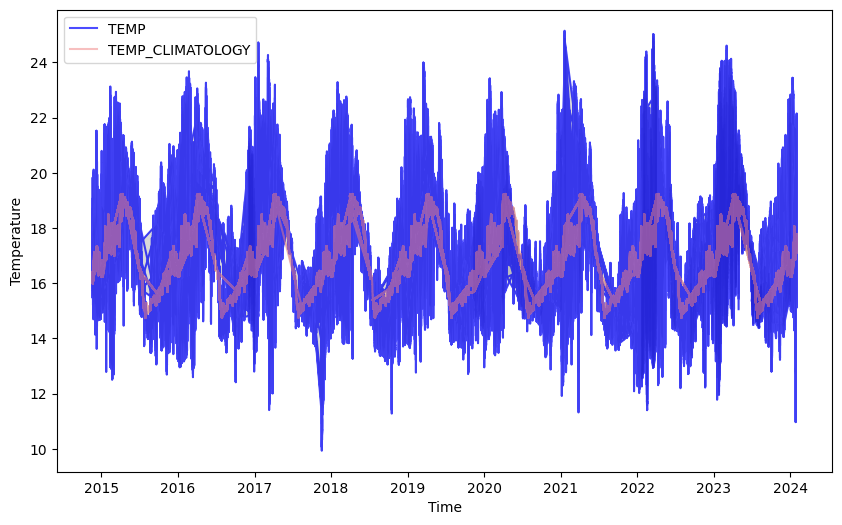

In [18]:
import matplotlib.pyplot as plt

# Plot TEMP and TEMP_CLIMATOLOGY
plt.figure(figsize=(10, 6))
plt.plot(df['TIME'], df['TEMP'], label='TEMP', color='blue', alpha=0.7)
plt.plot(df['TIME'], df['TEMP_CLIMATOLOGY'], label='TEMP_CLIMATOLOGY', color='lightcoral', alpha=0.5)

# Fill between TEMP and TEMP_CLIMATOLOGY
plt.fill_between(df['TIME'], df['TEMP'], df['TEMP_CLIMATOLOGY'], color='gray', alpha=0.3)

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()

# Show the plot
plt.show()

#### Interactive plot with hvplot

In [19]:
import hvplot.pandas  # Import hvplot extension for pandas DataFrame
import holoviews as hv

ImportError: cannot import name 'Box' from 'bokeh.models' (/home/raymond/anaconda3/envs/data-access-service/lib/python3.10/site-packages/bokeh/models/__init__.py)

In [ ]:
df = df[df["NOMINAL_DEPTH"] == 52].sort_values('TIME')

In [ ]:
# Create hvplot line plots for TEMP and TEMP_CLIMATOLOGY
temp_plot = df.hvplot.line(x='TIME', y='TEMP', label='TEMP', color='blue', ylabel='Temperature', xlabel='Time')
climatology_plot = df.hvplot.line(x='TIME', y='TEMP_CLIMATOLOGY', label='TEMP_CLIMATOLOGY', color='lightcoral')

overlay = (temp_plot * climatology_plot)

# Create a shaded area between the two line plots
filled_area = hv.Area((df['TIME'], df['TEMP'], df['TEMP_CLIMATOLOGY']), vdims=['TEMP', 'TEMP_CLIMATOLOGY']).opts(alpha=0.3, color='gray')

# Combine the line plot overlay with the filled area
combined_plot = (overlay * filled_area).opts(width=800, height=400, responsive=True)

# Show the combined plot
combined_plot